In [1]:
from src.config import config
import pandas as pd
import os
img_dir = os.path.join(config["DATA_DIR"], "3D_val_npz")
gts_dir = os.path.join(config["DATA_DIR"], "3D_val_gt_interactive_seg")
output_dir = os.path.join(config["RESULTS_DIR"], "simple")

Loaded configuration for machine: nora


In [5]:
# get our and baseline metrics


evalmetrics_df = pd.read_csv(os.path.join(output_dir, "norateam_metrics_2130_cases.csv"))
baselinesmetrics_df = pd.read_csv(os.path.join(config["RESULTS_DIR"], "CVPR25-Baseline-ValidationResults - interactive-seg-coreset.csv"))
nninteractivemetrics_df = pd.read_csv(os.path.join(config["RESULTS_DIR"], "nninteractive_metrics_combined.csv"))
print(len(evalmetrics_df))
print(len(baselinesmetrics_df))
print(len(nninteractivemetrics_df))

2130
2145
2070


In [6]:
# get spacing, shape and has_bbox for each case
import numpy as np
dscs = []
nsds = []
spacings = []
shapes = []
evalmetrics_df["spacing"] = None
evalmetrics_df["spacing"] = evalmetrics_df["spacing"].astype(object)
evalmetrics_df["shape"] = None
evalmetrics_df["shape"] = evalmetrics_df["shape"].astype(object)
evalmetrics_df["has_bbox"] = None
for i, case_filename in enumerate(evalmetrics_df['CaseName']):
    case_filename += ".npz"
    img_filepath = os.path.join(img_dir, case_filename)
    img_data = np.load(img_filepath)
    gt_filepath = os.path.join(gts_dir, case_filename)
    gt_data = np.load(gt_filepath)
    gts = gt_data["gts"]
    spacing = gt_data["spacing"]
    shape = gts.shape
    spacing = np.array(spacing)
    case_name = os.path.splitext(case_filename)[0]
    
    matching_indices = evalmetrics_df[evalmetrics_df['CaseName'] == case_name].index
    for idx in matching_indices:
        evalmetrics_df.at[idx, 'spacing'] = spacing
        evalmetrics_df.at[idx, 'shape'] = shape
        evalmetrics_df.at[idx, 'has_bbox'] = "boxes" in img_data

In [7]:
# add modality
evalmetrics_df['modality'] = evalmetrics_df['CaseName'].str[:2]


In [15]:
# see nb of common cases
common_cases = set(evalmetrics_df["CaseName"]).intersection(set(baselinesmetrics_df["CaseName"]))
print(f"Number of common cases: {len(common_cases)}")
# cases in evalmetrics_df but not in baselinesmetrics_df
missing_cases = set(evalmetrics_df["CaseName"]) - set(baselinesmetrics_df["CaseName"])
print(f"Number of cases in evalmetrics_df but not in baselinesmetrics_df: {len(missing_cases)}")
# cases in baselinesmetrics_df but not in evalmetrics_df
missing_baselines_cases = set(baselinesmetrics_df["CaseName"]) - set(evalmetrics_df["CaseName"])
print(f"Number of cases in baselinesmetrics_df but not in evalmetrics_df: {len(missing_baselines_cases)}")

Number of common cases: 2094
Number of cases in evalmetrics_df but not in baselinesmetrics_df: 36
Number of cases in baselinesmetrics_df but not in evalmetrics_df: 51


In [8]:
baselinesmetrics_df["CaseName"] = baselinesmetrics_df["CaseName"].str.replace(".npz", "")
nninteractivemetrics_df["CaseName"] = nninteractivemetrics_df["CaseName"].str.replace(".npz", "")
# add "ours_" prefix to columns from evalmetrics_df
evalmetrics_df = evalmetrics_df.rename(columns=lambda x: f"ours_{x}" if x not in ["CaseName", "spacing", "shape", "has_bbox", "modality"] else x)
# add "nninteractive_" prefix to columns from nninteractivemetrics_df
nninteractivemetrics_df = nninteractivemetrics_df.rename(columns=lambda x: f"nninteractive_{x}" if x not in ["CaseName", "spacing", "shape", "has_bbox", "modality"] else x)

In [9]:

# merge baselinesmetrics_df into evalmetrics_df
merged_df = evalmetrics_df.merge(baselinesmetrics_df, on="CaseName", how="left")
# merge nninteractivemetrics_df into merged_df
merged_df = merged_df.merge(nninteractivemetrics_df, on="CaseName", how="left")
print(len(merged_df))
print(merged_df.columns)
# modalities count
modality_counts = merged_df['modality'].value_counts()
print(modality_counts)



2130
Index(['CaseName', 'ours_TotalRunningTime', 'ours_RunningTime_1',
       'ours_RunningTime_2', 'ours_RunningTime_3', 'ours_RunningTime_4',
       'ours_RunningTime_5', 'ours_RunningTime_6', 'ours_DSC_AUC',
       'ours_NSD_AUC',
       ...
       'nninteractive_DSC_5', 'nninteractive_DSC_6', 'nninteractive_NSD_1',
       'nninteractive_NSD_2', 'nninteractive_NSD_3', 'nninteractive_NSD_4',
       'nninteractive_NSD_5', 'nninteractive_NSD_6', 'nninteractive_num_class',
       'nninteractive_runtime_upperbound'],
      dtype='object', length=101)
modality
MR    977
CT    897
US    108
Mi     83
PE     65
Name: count, dtype: int64


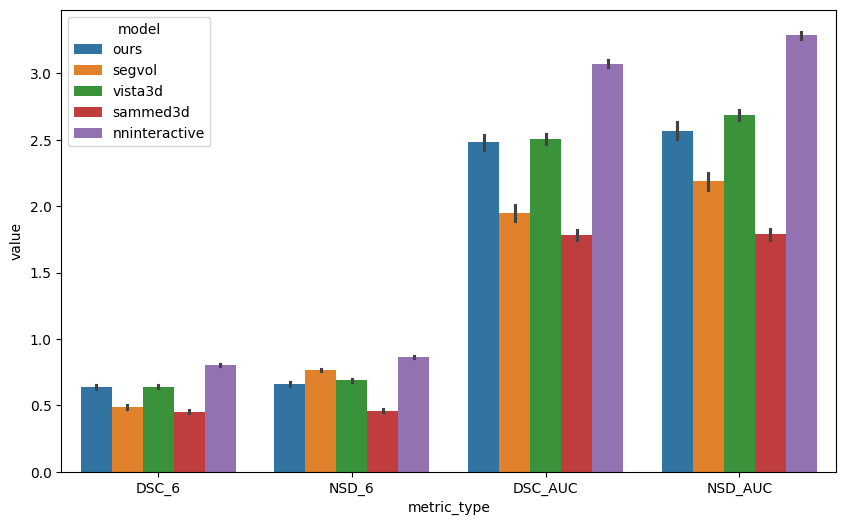

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

metrics_names = ["DSC_6", "NSD_6", "DSC_AUC", "NSD_AUC"]

# Find columns for each metric
metric_cols = []
for metric in metrics_names:
    cols = [col for col in merged_df.columns if metric in col]
    metric_cols.extend(cols)

# Melt data
melted = merged_df.melt(id_vars=['modality', 'has_bbox'], value_vars=metric_cols, 
                       var_name='metric', value_name='value')

# Extract metric type and model name
melted['metric_type'] = melted['metric'].apply(lambda x: next(m for m in metrics_names if m in x))
melted['model'] = melted['metric'].str.replace('_.*', '', regex=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='metric_type', y='value', hue='model')
plt.show()

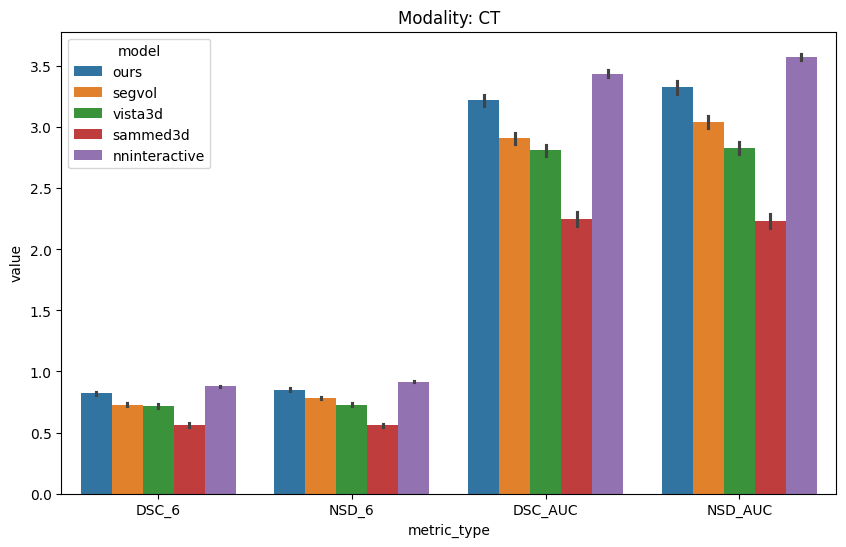

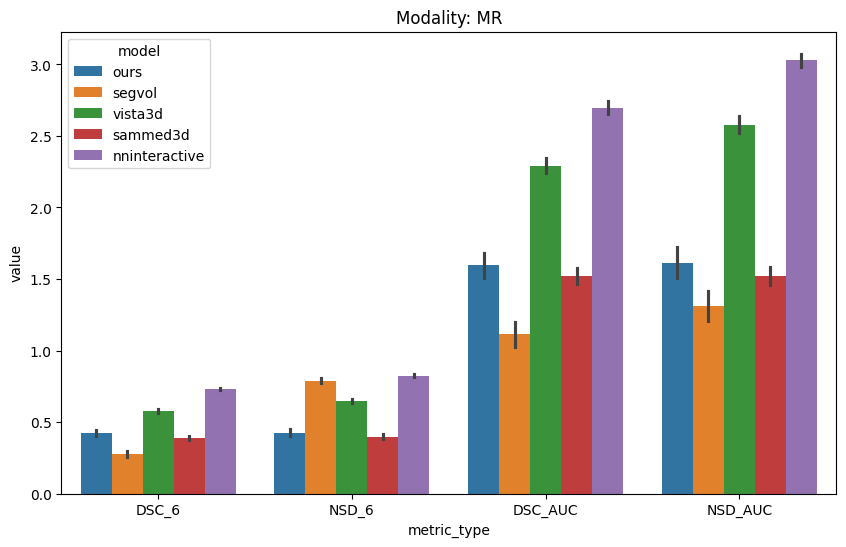

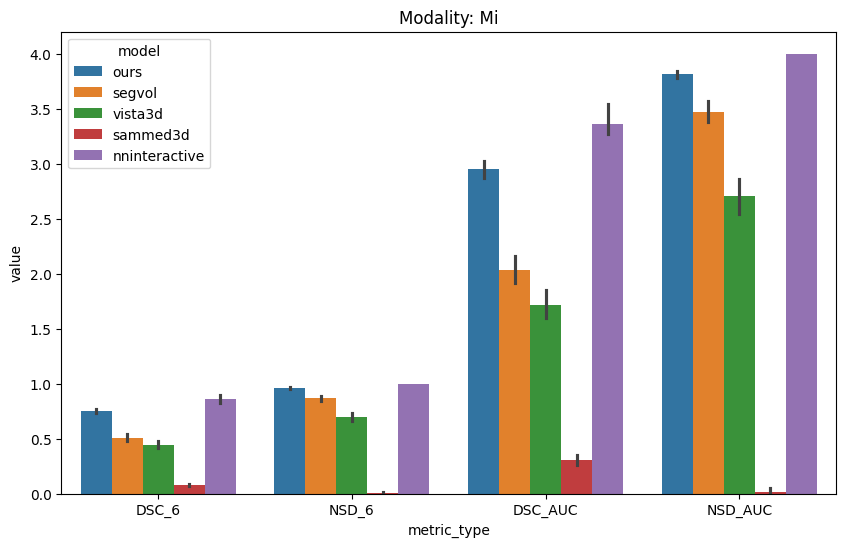

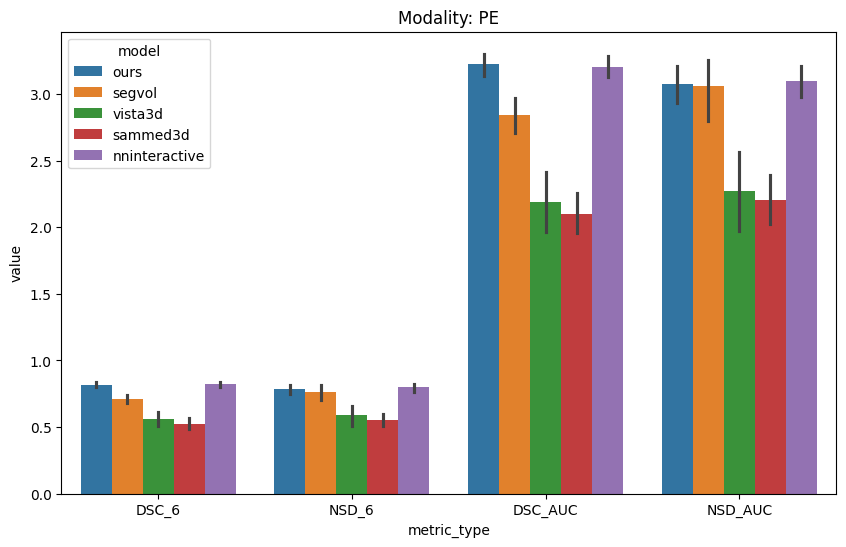

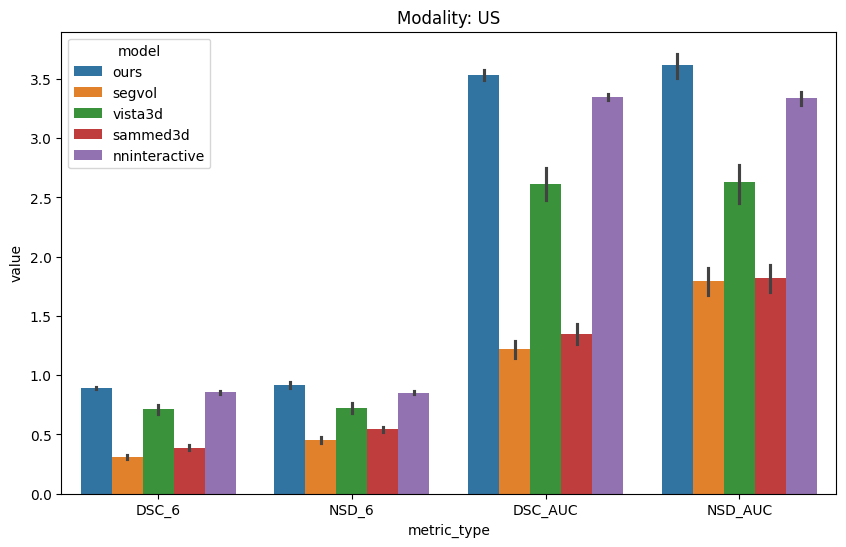

In [11]:
# Plot one per modality
for modality in merged_df['modality'].unique():
    plt.figure(figsize=(10, 6))
    data = melted[melted['modality'] == modality]
    sns.barplot(data=data, x='metric_type', y='value', hue='model')
    plt.title(f'Modality: {modality}')
    plt.show()

Plotting for has_bbox: True


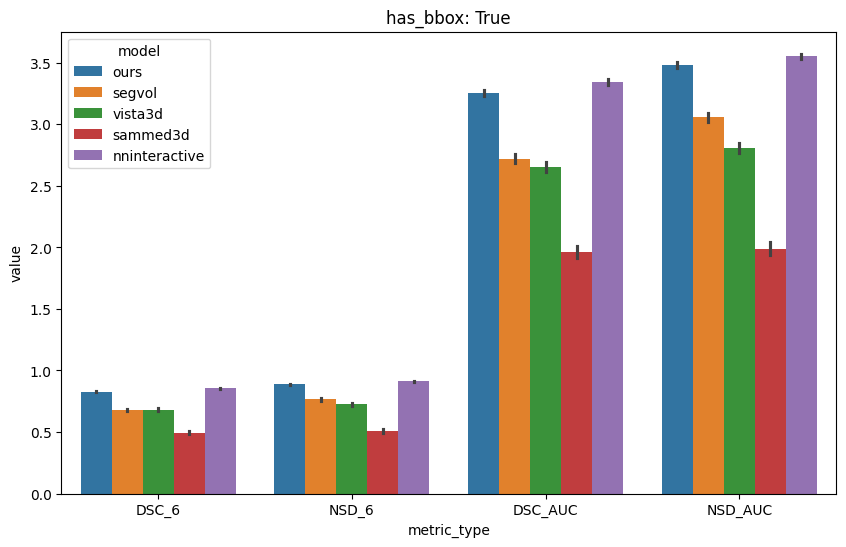

Plotting for has_bbox: False


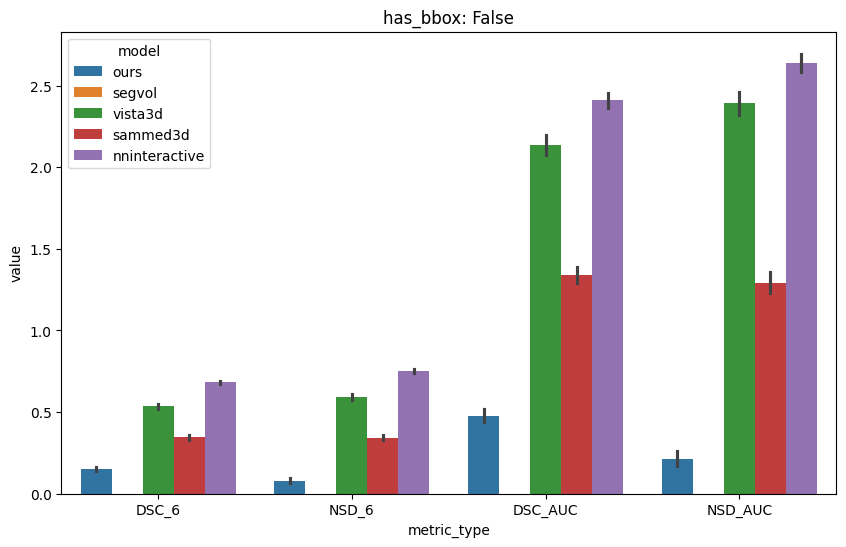

In [12]:
# Plot one per modality
for has_bbox in melted['has_bbox'].unique():
    print(f"Plotting for has_bbox: {has_bbox}")
    plt.figure(figsize=(10, 6))
    data = melted[melted['has_bbox'] == has_bbox]
    sns.barplot(data=data, x='metric_type', y='value', hue='model')
    plt.title(f'has_bbox: {has_bbox}')
    plt.show()

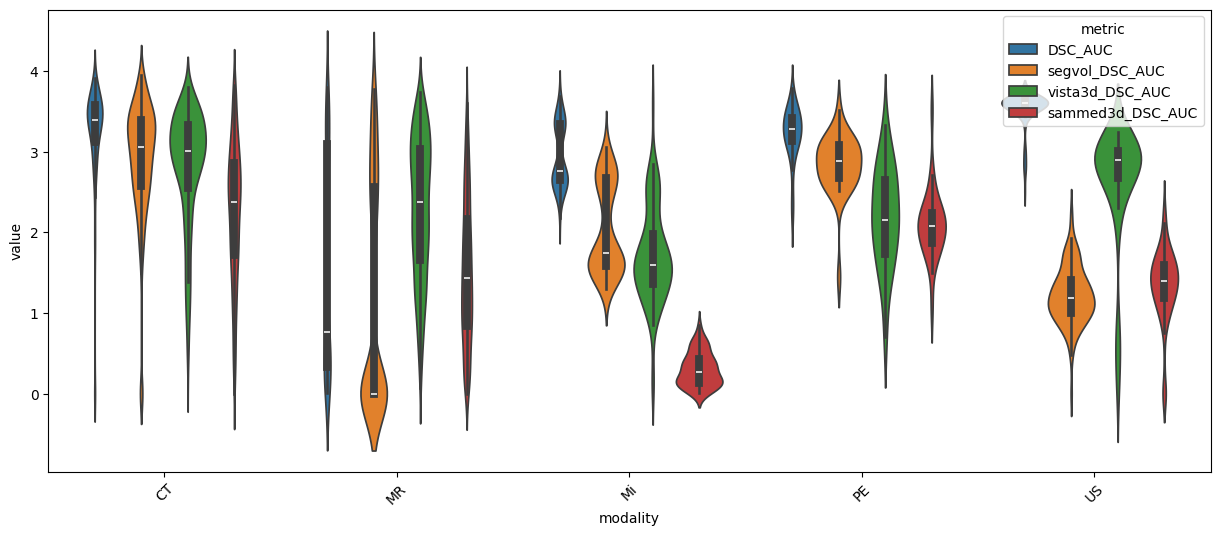

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Find DSC_AUC columns
dsc_cols = [col for col in merged_df.columns if 'DSC_AUC' in col]

# Melt data
melted = merged_df.melt(id_vars=['modality'], value_vars=dsc_cols, 
                       var_name='metric', value_name='value')

# Plot
plt.figure(figsize=(15, 6))
sns.violinplot(data=melted, x='modality', y='value', hue='metric')
plt.xticks(rotation=45)
plt.show()

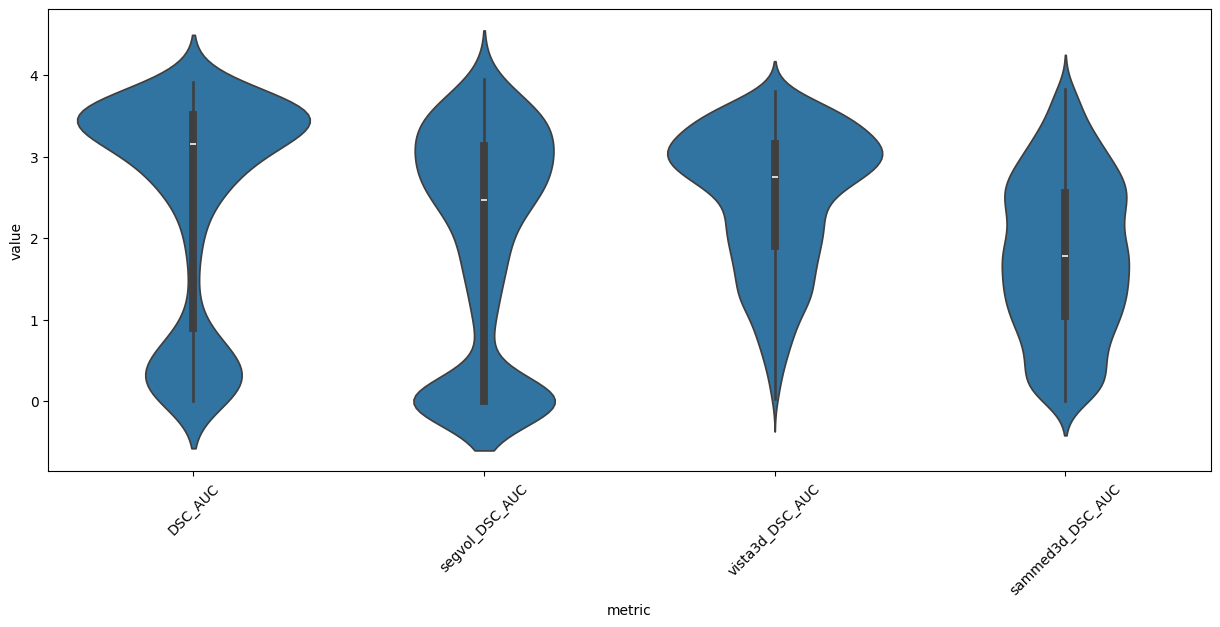

In [23]:

# Plot
plt.figure(figsize=(15, 6))
sns.violinplot(data=melted, x='metric', y='value')
plt.xticks(rotation=45)
plt.show()
